In [152]:
%matplotlib inline

In [153]:
import numpy as np
import pandas as pd

In [154]:
import cv2

In [155]:
import matplotlib.pyplot as plt

In [156]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from utils.postprocessing import morph_masks
from utils.plotting import plot_mask
from predict import get_prediction_filename

# Load dataset

In [157]:
nb_folds = 5
fold_number = 4
model_name = 'unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [158]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [159]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [160]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [161]:
images = np.stack(images)
masks = np.stack(masks)

In [162]:
images.shape, masks.shape

((33, 500, 500, 3), (33, 500, 500))

## Load predictions

In [163]:
filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
_, predictions = load_pickle(filename)

In [164]:
threshold = 0.3

In [165]:
predictions_mask = np.zeros_like(predictions)
predictions_mask[predictions>threshold] = 1

In [166]:
predictions.shape, predictions_mask.shape

((33, 500, 500), (33, 500, 500))

## Get score

In [167]:
score = topcoder_metric(masks, predictions_mask)

In [168]:
print('Score:', score)

Score: 832823.951807


# Post-processing

In [169]:
scores = []
for kernel_size in range(1,20, 2):
    predictions_mask_opened = morph_masks(predictions_mask, kernel_size, operation='open')
    predictions_mask_closed = morph_masks(predictions_mask, kernel_size, operation='close')    
    predictions_mask_opened_closed = morph_masks(
        morph_masks(predictions_mask, kernel_size, operation='open'),
        kernel_size, operation='close'
    )

    
    score_opened = topcoder_metric(masks, predictions_mask_opened)
    score_closed = topcoder_metric(masks, predictions_mask_closed)
    score_opened_closed = topcoder_metric(masks, predictions_mask_opened_closed)    
    
    scores.append({'score_open': score_opened, 'score_close': score_closed, 'score_open_close': score_opened_closed, 'kernel_size': kernel_size})

scores = pd.DataFrame(scores)

In [170]:
scores

,kernel_size,score_close,score_open,score_open_close
0,1,832823.951807,832823.951807,832823.951807
1,3,832696.734835,832976.569255,832897.132775
2,5,832410.018874,833167.395213,832864.957850
3,7,831933.523750,833375.560954,832689.590061
4,9,831001.969604,833713.029232,832275.712321
5,11,829900.191498,834536.925577,832347.805099
6,13,828822.332550,834751.116104,831727.116299
7,15,826752.753541,835251.600252,830903.378820
8,17,825210.903923,835163.194901,829883.436389
9,19,822813.615521,835067.589421,828265.313960


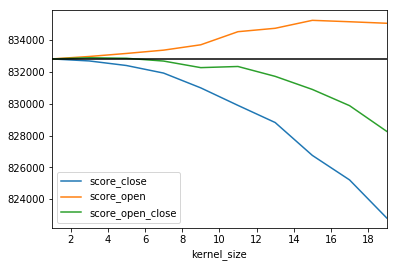

In [171]:
ax = scores.plot(x='kernel_size', y=['score_close', 'score_open', 'score_open_close'])
ax.axhline(y=score, c='black')

In [172]:
# 0 - 13
# 1 - 6
# 2 - 13
# 3 - 9
# 4 - 17

In [173]:
(13 + 6 + 13 + 9 + 17) / 5

11.6

# Plot some masks

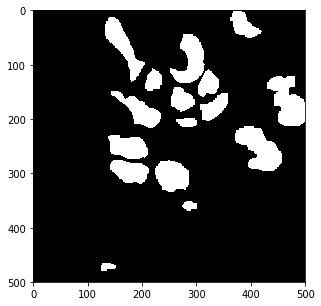

In [174]:
plot_mask(masks[1])

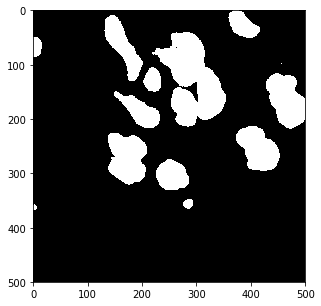

In [175]:
plot_mask(predictions_mask[1])

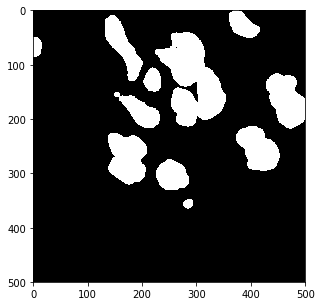

In [176]:
plot_mask(morph_masks(predictions_mask[1], kernel_size=11))

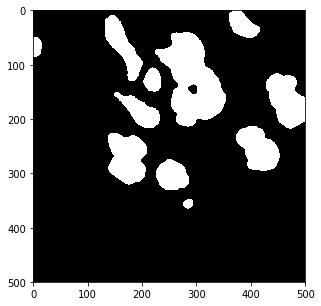

In [177]:
plot_mask(morph_masks(morph_masks(predictions_mask[1], kernel_size=11), kernel_size=11, operation='close'))